## Federated Quasi Newton Learn
Here is proposed a version of the Federated Newton Learn algorithm combined with some of the ideas behind the quasi Newton method.

In [4]:
from ipyparallel import Client
c = Client()
c.ids

[0, 1]

In [9]:
%%px
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl
from copy import copy, deepcopy

comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]

tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
#Defining the Loss Function
def LossSerial(x):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0]) + lam*tf.norm(x)**2

    return S
#Defining the Loss Function
def Loss(x,comm):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0]) + lam*tf.norm(x)**2
    return S
################! Setting Of The Solver!##################
itmax = 100
tol = 1e-4;
N = 119;
step_size = 2.0
avg = False;

bkitmax = 1;
tau = 0.5
c = 0.5;
###########################################################
Residuals = [];
TBCHistory = [];
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))
LossStar =  0.33691510558128357;
print(np.abs(LossSerial(x)-LossStar))
H = Hessian(Loss,x);
Hm = Hessian(Loss,x);
M = H.comm.Get_size();
H.shift(x, opt={"type":"act"},start=H.vecprod)
#We now collect and average the loc Hessians in the master node (rk 0)
initU, initS, initVt = H.RandMatSVD(109,10);
#init = initU@np.diag(initS)@initVt;
init = H.mat()
Inits = H.comm.gather(init, root=0)
InitUs = H.comm.gather(initU, root=0)
InitSs = H.comm.gather(initS, root=0)
InitVts = H.comm.gather(initVt, root=0)

if H.comm.Get_rank()==0:
    QInv = np.linalg.inv((1/len(Inits))*np.sum(Inits,0))
    print("Gatherd QInv");
    UInv = (1/len(InitUs))*np.sum(InitUs,0)
    print("Gatherd Us");
    SInv = (1/len(InitSs))*np.sum(InitSs,0)
    print("Gatherd Ss");
    VtInv = (1/len(InitVts))*np.sum(InitVts,0)
    print("Gatherd Vts");
    print("Frobenious norm of real QInv is: {}.",np.linalg.norm(QInv,ord="fro"))
    print("Largest singular value of the decomposition is: {}.",SInv[0])
    QInv = VtInv.T@np.diag([1/s for s in SInv])@UInv.T;
else:
    QInv = None;

print("The master Hessian has been initialised")
for it in tqdm(range(itmax)):
    # Obtaining the compression of the difference between local mat
    # and next local mat.
    U,sigma,Vt = H.shift(x,{"comp":ActHalko,"rk":1,"type":"act"});
    #print("TBC: {}".format(sigma[0]));
    #print("Updating local Hessian")
    Hm = Hessian(Loss,x);
    H.memH =copy(Hm.vecprod);
    grad = H.grad().numpy();
    #Now we update the master Hessian and perform the Newton method step
    ShiftUs = H.comm.gather(U, root=0);
    ShiftVs = H.comm.gather(sigma[0]*Vt, root=0);
    Grads = H.comm.gather(grad, root=0);
    Umat = np.zeros((N,H.comm.Get_size()));
    Vmat = np.zeros((H.comm.Get_size(),N));
    if H.comm.Get_rank() == 0:
        #print("Computing the avarage of the local shifts and grad ...")
        if not avg:
            for j in range(H.comm.Get_size()):
                Umat[:,j] = ShiftUs[j].reshape(N,);
                Vmat[j,:] = ShiftVs[j];
            Uu, Su, Vut = np.linalg.svd(Umat);
            Uv, Sv, Vvt = np.linalg.svd(Vmat);
            #Building the Rank 1 approximation
            u = Uu[:,0].reshape((N,1));
            v = (Su[0]*Sv[0])*Vut[0,:].reshape(1,M)@Uv[:,0].reshape(M,1)@Vvt[0,:].reshape(1,N)
        else:
            u = (1/len(ShiftUs))*np.sum(ShiftUs,0);
            v = (1/len(ShiftVs))*np.sum(ShiftVs,0);
        Grad = (1/len(Grads))*np.sum(Grads,0);
        res = np.linalg.norm(Grad);
        Residuals = Residuals + [res];
        TBCHistory = TBCHistory + [sigma[0]];
        #print("Computing the master Hessian ...")
        #SHERMAN-MORRISON
        normal = (1+v@QInv@u);
        #print("Normalisation: ",normal);
        A = QInv@u@v@QInv;
        #print("Searching new search direction ...")
        QInv = QInv - (1/(1+normal))*A;
        #Back traking
        step = step_size;
        q =  QInv@Grad;
        for bkit in range(bkitmax):
                m = Grad.T@q
                t = -c*m;
                if LossSerial(x)-LossSerial(x - tf.Variable(step*q,dtype=np.float32))>step*tau:
                    break
                else:
                    step = tau*step;
        #print("Found search dir, ",q.shape);
        if it%10 == 0:
            print("(FedNL) [Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}, back tracing it {} and step {}.".format(it,LossSerial(x),np.linalg.norm(Grad),bkit,step));
        x = x - tf.Variable(step*q,dtype=np.float32);
        x =  tf.Variable(x)
    else:
        res = None
    #Distributing the search direction
    x = H.comm.bcast(x,root=0)
    res = H.comm.bcast(res,root=0)
    if res<tol:
            break
print("Lost funciton at this iteration {}, gradient norm {} and error {}.".format(LossSerial(x),np.linalg.norm(grad),abs(LossSerial(x)-LossStar)))

[stdout:0] 0.93067896
Gatherd QInv
Gatherd Us
Gatherd Ss
Gatherd Vts
Frobenious norm of real QInv is: {}. 1821.6798
Largest singular value of the decomposition is: {}. 2.0067791221984637
The master Hessian has been initialised
(FedNL) [Iteration. 0] Lost funciton at this iteration 1.2675940990447998  and gradient norm 1.388305902481079, back tracing it 0 and step 1.0.
(FedNL) [Iteration. 10] Lost funciton at this iteration 0.3394237160682678  and gradient norm 0.00981062650680542, back tracing it 0 and step 1.0.
(FedNL) [Iteration. 20] Lost funciton at this iteration 0.3371833562850952  and gradient norm 0.00253682560287416, back tracing it 0 and step 1.0.
(FedNL) [Iteration. 30] Lost funciton at this iteration 0.3369591534137726  and gradient norm 0.0009783405112102628, back tracing it 0 and step 1.0.
(FedNL) [Iteration. 40] Lost funciton at this iteration 0.33692294359207153  and gradient norm 0.0004042017098981887, back tracing it 0 and step 1.0.
(FedNL) [Iteration. 50] Lost funcito

[stdout:1] 0.93067896
The master Hessian has been initialised
Lost funciton at this iteration 0.336915522813797, gradient norm 0.02016419731080532 and error 4.172325134277344e-07.


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1]  57%|█████▋    | 57/100 [00:08<00:06,  6.86it/s]


[stderr:0]  57%|█████▋    | 57/100 [00:08<00:06,  6.86it/s]


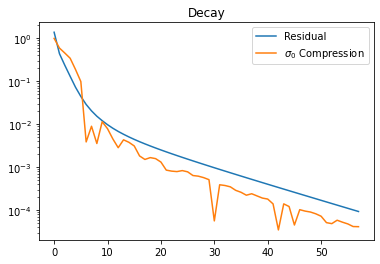

In [10]:
import matplotlib.pyplot as plt
Rs = c[:]["Residuals"][0]
plt.semilogy(range(len(Rs)),Rs)
plt.title("Residual Decay")
TBCs = c[:]["TBCHistory"][0]
TBCs[0]=1.
plt.semilogy(range(len(TBCs)),TBCs)
plt.title("Decay")
plt.legend(["Residual",r"$\sigma_0$ Compression"])

### Comparison Newton, Quasi-Newton, FEDNL, FEDQNL

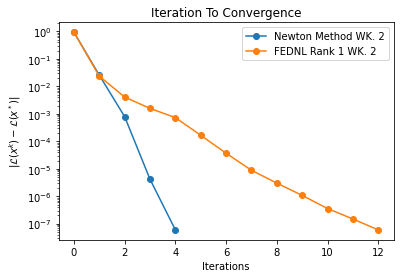

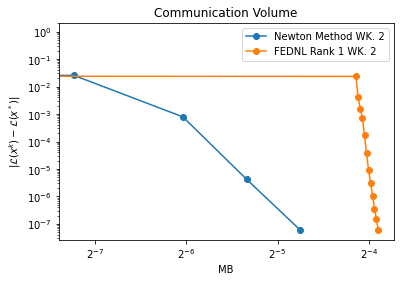

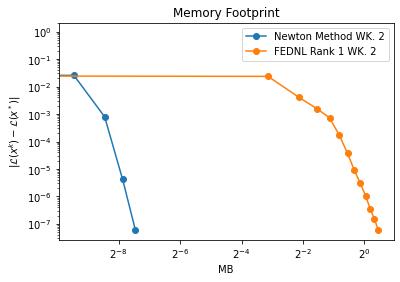

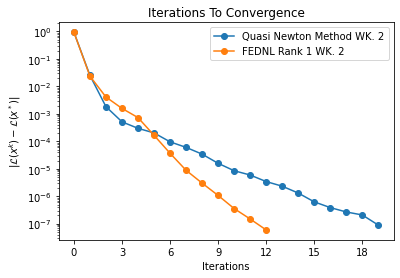

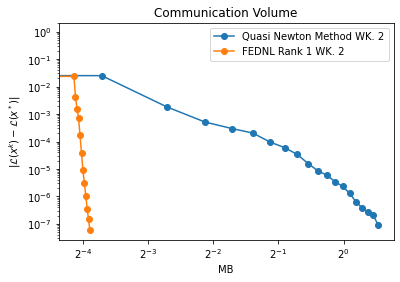

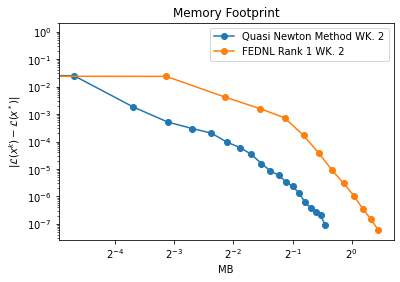

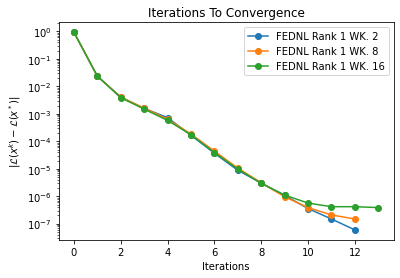

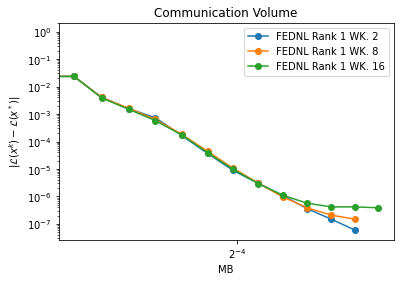

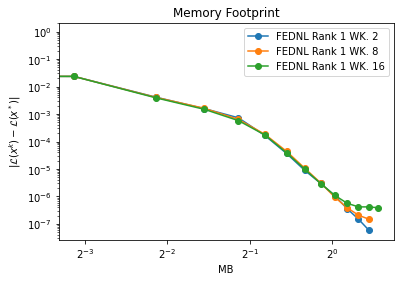

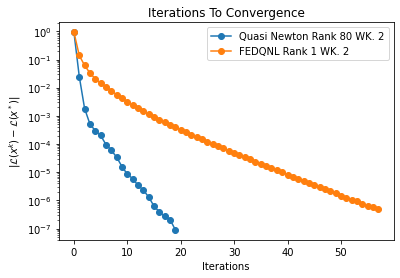

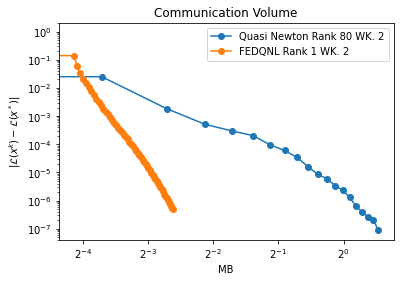

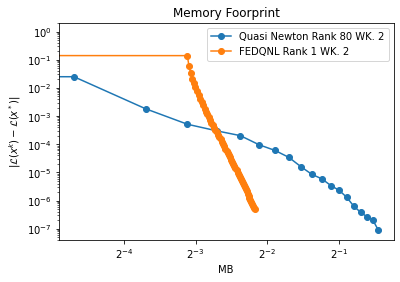

In [1]:
from compareNL import compareNL
compareNL(0,0)